In [1]:
import uproot4
import numpy as np
import numba
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
from coffea import hist
from coffea.processor import defaultdict_accumulator
import os
import copy

import optparse
import importlib
import pathlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

#Just to efficiently save plots
plot_dir = "plot/"
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

print("Saving plots to: ", save_path)

#Plot settings
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

## Data processing codes
def getData(fname="", treeName="Truth"):
    dq_dict_ak1 = uproot4.lazy(fname+":"+treeName)
    dq_events = ak.zip({
                        "nTrack": ak.zip({
                                "n_tracks": dq_dict_ak1['n_tracks']
                        }),
                        "GenVertex": ak.zip({
                                            "x": dq_dict_ak1["gvx"],
                                            "y": dq_dict_ak1["gvy"],
                                            "z": dq_dict_ak1["gvz"],
                                            "px": dq_dict_ak1["gpx"],
                                            "py": dq_dict_ak1["gpy"],
                                            "pz": dq_dict_ak1["gpz"]

                        }),
                        "GenP_St1": ak.zip({
                                            "px": dq_dict_ak1["gpx_st1"],
                                            "py": dq_dict_ak1["gpy_st1"],
                                            "pz": dq_dict_ak1["gpz_st1"],
                                            "x": dq_dict_ak1["gx_st1"],
                                            "y": dq_dict_ak1["gy_st1"],
                                            "z": dq_dict_ak1["gz_st1"],
                        }),
                        "Track_St1": ak.zip({
                                            "px": dq_dict_ak1["track_px_st1"],
                                            "py": dq_dict_ak1["track_py_st1"],
                                            "pz": dq_dict_ak1["track_pz_st1"],
                                            "x": dq_dict_ak1["track_x_st1"],
                                            "y": dq_dict_ak1["track_y_st1"],
                                            "z": dq_dict_ak1["track_z_st1"],
                        }),
                        "reco_dimuon": ak.zip({
                                            "mass": dq_dict_ak1["dimuon_mass"],
                                            "x": dq_dict_ak1["dimuon_x_vtx"],
                                            "y": dq_dict_ak1["dimuon_y_vtx"],
                                            "z": dq_dict_ak1["dimuon_z_vtx"],
                                            "n_px": dq_dict_ak1["dimuon_nmom_x"],
                                            "n_py": dq_dict_ak1["dimuon_nmom_y"],
                                            "n_pz": dq_dict_ak1["dimuon_nmom_z"],
                                            "p_px": dq_dict_ak1["dimuon_pmom_x"],
                                            "p_py": dq_dict_ak1["dimuon_pmom_y"],
                                            "p_pz": dq_dict_ak1["dimuon_pmom_z"],
                                            "chisq": dq_dict_ak1["dimuon_chisq"],
                            
                        }),
                        "truth_dimuon":ak.zip({
                                            "mass": dq_dict_ak1['truthdimuon_mass'],
                                            "x": dq_dict_ak1['truthdimuon_x_vtx'],
                                            "y": dq_dict_ak1['truthdimuon_y_vtx'],
                                            "z": dq_dict_ak1['truthdimuon_z_vtx'],
                                            "px": dq_dict_ak1['truthdimuon_px'],
                                            "py": dq_dict_ak1['truthdimuon_py'],
                                            "pz": dq_dict_ak1['truthdimuon_pz'],
                            
                        })
                       }, depth_limit=1)
    return dq_events


######## READ EVENTS
filename = "/data/t3home000/dhoang/DQ/outfiles/DY_Jun1621_100k.root"
dq_events = getData(filename, treeName = 'Events')

Saving plots to:  plot/21-06-2021


## DY dimuon resolution plot

Truth momentum range: 30,40 GeV
Error for parameter esimations:  [0.00659786 0.06491363 0.05132546]
Standard deviation (fit) is 2.2060007589590676
Mean (fit) is 0.15215634527658098
Resolution (fit) is 14.49825017122439
Truth momentum range: 40,50 GeV
Error for parameter esimations:  [0.0043435  0.08450468 0.06686612]
Standard deviation (fit) is 3.097855646256297
Mean (fit) is 0.0924202006960506
Resolution (fit) is 33.51924820466959
Truth momentum range: 50,60 GeV
Error for parameter esimations:  [0.00344431 0.11459819 0.08849859]
Standard deviation (fit) is 4.023153243000699
Mean (fit) is -0.2545687503512888
Resolution (fit) is -15.803798531630461
Truth momentum range: 60,70 GeV
Error for parameter esimations:  [0.00452846 0.22583797 0.18255844]
Standard deviation (fit) is 4.8350202720359565
Mean (fit) is -0.3807388486329625
Resolution (fit) is -12.69904631323026


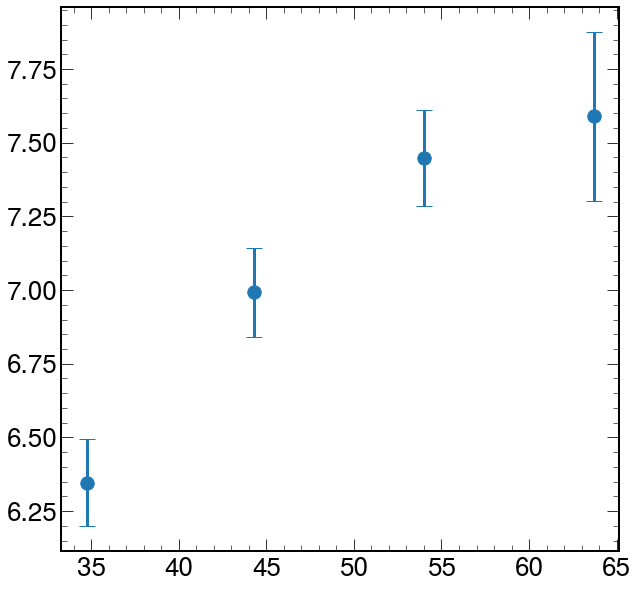

In [2]:
def concatenate_p(n_mom, p_mom):
    
    return np.transpose(np.stack((n_mom, p_mom)))

def match_p(truth_vertex_p, reco_vertex_p):
    
    #Dictionary to hold saved arrays
    mom_dict = {}
    
    #Max case
    mom_dict['truth_pmax'] = np.amax(truth_vertex_p, axis = 1)
    mom_dict['reco_pmax'] =  np.amax(reco_vertex_p, axis = 1)

    #min case
    mom_dict['truth_pmin'] = np.amin(truth_vertex_p, axis = 1)
    mom_dict['reco_pmin'] = np.amin(reco_vertex_p, axis = 1)
    
    matched_truth_vertex_p = np.asarray(np.concatenate((mom_dict['truth_pmax'], mom_dict['truth_pmin'])))
    matched_reco_vertex_p =  np.asarray(np.concatenate((mom_dict['reco_pmax'], mom_dict['reco_pmin'])))
    
    return matched_truth_vertex_p, matched_reco_vertex_p

def match_truth_and_reco_p(dq_events):
    
    #Select the events that are reconstructed
    reco_selection = (ak.num(dq_events["reco_dimuon"].n_px) > 0) &\
                     (ak.num(dq_events["truth_dimuon"].mass) < 2) #Remove those with 4 truth muons
    
    #Momentum of truth muons at vertex
    truth_vertex_p =  np.asarray(np.sqrt(dq_events["GenVertex"][reco_selection].px**2 +\
                              dq_events["GenVertex"][reco_selection].py**2 +\
                              dq_events["GenVertex"][reco_selection].pz**2))

    #Momentum of reco muons at vertex
    reco_vertex_n_px = np.squeeze(np.asarray(dq_events["reco_dimuon"].n_px[reco_selection]))
    reco_vertex_n_py = np.squeeze(np.asarray(dq_events["reco_dimuon"].n_py[reco_selection]))
    reco_vertex_n_pz = np.squeeze(np.asarray(dq_events["reco_dimuon"].n_pz[reco_selection]))
    
    reco_vertex_p_px = np.squeeze(np.asarray(dq_events["reco_dimuon"].p_px[reco_selection]))
    reco_vertex_p_py = np.squeeze(np.asarray(dq_events["reco_dimuon"].p_py[reco_selection]))
    reco_vertex_p_pz = np.squeeze(np.asarray(dq_events["reco_dimuon"].p_pz[reco_selection]))
    
    #Concatenate them
    reco_vertex_px = concatenate_p(reco_vertex_n_px, reco_vertex_p_px)
    reco_vertex_py = concatenate_p(reco_vertex_n_py, reco_vertex_p_py)
    reco_vertex_pz = concatenate_p(reco_vertex_n_pz, reco_vertex_p_pz)
    
    #calcualte the whole thing
    reco_vertex_p =  np.sqrt(reco_vertex_px**2 +\
                             reco_vertex_py**2 +\
                             reco_vertex_pz**2)
    
    #Match the conrresponding momenta
    matched_truth_vertex_p, matched_reco_vertex_p = match_p(truth_vertex_p, reco_vertex_p)
    
    return matched_truth_vertex_p, matched_reco_vertex_p


def dimuon_resolution_before_fmag(dq_events):
    
    truth_p, reco_p = match_truth_and_reco_p(dq_events)
    
    p_resolution = [] #To save the resolution (sigma) of the fit
    p_average = []
    p_ranges = []
    p_err = []
    
    #Specify the ranges to calculate the resolution in 
    for i in range(3,7):
        
        hist_range = [-20,20]
        
        p_range = 10
        p_min = i*p_range #GeV
        p_max = (i+1)*p_range
        p_ranges.append([p_min,p_max]) #Save for resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (truth_p > p_min) & (truth_p < p_max)
        p_average.append(np.mean(truth_p[local_selection]))
        
        p_residual = copy.deepcopy(reco_p[local_selection] - truth_p[local_selection])
        
        if p_residual.size != 0:

            ## Gaussian fit
            ## Fit directly on the histogram
            def fit_function(x, A, mu, sig):
                return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

            bins = np.linspace(hist_range[0], hist_range[1], 51)
            binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
            data_entries, _ = np.histogram(p_residual, bins=bins,
                                           range = hist_range, density = True)

            mask = data_entries!=0
            #Fit the function to the histogram data.
            popt, pcov = curve_fit(fit_function,
                                   xdata=binscenters[mask],
                                   ydata=data_entries[mask],
                                   sigma = np.sqrt(data_entries[mask]),
                                   absolute_sigma = False,
                                   p0=[1, 0, 0.5])

            #Error for parameter estimations
            perr = np.sqrt(np.diag(pcov))
            print("Error for parameter esimations: ", perr)
            p_err.append(perr[2])

            std_fit = np.abs(popt[2])
            mean_fit = popt[1]
            res_fit = std_fit/mean_fit
            sigma_res = perr[2]/mean_fit
            print("Standard deviation (fit) is", std_fit)
            print("Mean (fit) is", mean_fit)
            print("Resolution (fit) is {}".format(res_fit))
            p_resolution.append(std_fit)

        
    #MAIN PLOT   
    #Plot the resolution based on momentum range. 
    plt.scatter(p_average,
               [x/y*100 for x, y in zip(p_resolution, p_average)],
                s = 180,
                label= "Drell-Yan muons (Target)")

    #Plot the error bars
    plt.errorbar(p_average,
                [x/y*100 for x, y in zip(p_resolution, p_average)],
                yerr=[x/y*100 for x, y in zip(p_err, p_average)],
                fmt='none',
                elinewidth=3,
                capsize=8)
    
dimuon_resolution_before_fmag(dq_events)

In [3]:
def match_truth_and_reco_p_1(dq_events):
    
    #Select the events that are reconstructed
    reco_selection = (ak.num(dq_events["Track_St1"].px) == 2) &\
                     (ak.num(dq_events["truth_dimuon"].mass) < 2) #Remove those with 4 truth muons
    
    #Momentum of truth muons at st1
    truth_vertex_p =  np.asarray(np.sqrt(dq_events["GenP_St1"][reco_selection].px**2 +\
                              dq_events["GenP_St1"][reco_selection].py**2 +\
                              dq_events["GenP_St1"][reco_selection].pz**2))
    
    #calcualte the whole thing
    reco_vertex_p =  np.asarray(np.sqrt(dq_events["Track_St1"][reco_selection].px**2 +\
                             dq_events["Track_St1"][reco_selection].py**2 +\
                             dq_events["Track_St1"][reco_selection].pz**2))
    
    #Match the conrresponding momenta
    matched_truth_vertex_p, matched_reco_vertex_p = match_p(truth_vertex_p, reco_vertex_p)
    
    return matched_truth_vertex_p, matched_reco_vertex_p

def dimuon_resolution_after_fmag(dq_events):
    
    truth_p, reco_p = match_truth_and_reco_p_1(dq_events)
    
    p_resolution = [] #To save the resolution (sigma) of the fit
    p_average = []
    p_ranges = []
    p_err = []
    
    #Specify the ranges to calculate the resolution in 
    for i in range(3,7):
        
        hist_range = [-5,5]
        
        p_range = 10
        p_min = i*p_range #GeV
        p_max = (i+1)*p_range
        p_ranges.append([p_min,p_max]) #Save for resolution later
        
        print("Truth momentum range: {},{} GeV".format(p_min, p_max))
        
        local_selection = (truth_p > p_min) & (truth_p < p_max)
        p_average.append(np.mean(truth_p[local_selection]))
        
        p_residual = copy.deepcopy(reco_p[local_selection] - truth_p[local_selection])
        
        if p_residual.size != 0:

            ## Gaussian fit
            ## Fit directly on the histogram
            def fit_function(x, A, mu, sig):
                return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

            bins = np.linspace(hist_range[0], hist_range[1], 51)
            binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
            data_entries, _ = np.histogram(p_residual, bins=bins,
                                           range = hist_range, density = True)

            mask = data_entries!=0
            #Fit the function to the histogram data.
            popt, pcov = curve_fit(fit_function,
                                   xdata=binscenters[mask],
                                   ydata=data_entries[mask],
                                   sigma = np.sqrt(data_entries[mask]),
                                   absolute_sigma = False,
                                   p0=[1, 0, 0.5])

            #Error for parameter estimations
            perr = np.sqrt(np.diag(pcov))
            print("Error for parameter esimations: ", perr)
            p_err.append(perr[2])

            std_fit = np.abs(popt[2])
            mean_fit = popt[1]
            res_fit = std_fit/mean_fit
            sigma_res = perr[2]/mean_fit
            print("Standard deviation (fit) is", std_fit)
            print("Mean (fit) is", mean_fit)
            print("Resolution (fit) is {}".format(res_fit))
            p_resolution.append(std_fit)

        
    #MAIN PLOT   
    #Plot the resolution based on momentum range. 
    plt.scatter(p_average,
               [x/y*100 for x, y in zip(p_resolution, p_average)],
                s = 180,
                label= "Drell-Yan muons (Station 1)")

    #Plot the error bars
    plt.errorbar(p_average,
                [x/y*100 for x, y in zip(p_resolution, p_average)],
                yerr=[x/y*100 for x, y in zip(p_err, p_average)],
                fmt='none',
                elinewidth=3,
                capsize=8)

Truth momentum range: 30,40 GeV
Error for parameter esimations:  [0.00659786 0.06491363 0.05132546]
Standard deviation (fit) is 2.2060007589590676
Mean (fit) is 0.15215634527658098
Resolution (fit) is 14.49825017122439
Truth momentum range: 40,50 GeV
Error for parameter esimations:  [0.0043435  0.08450468 0.06686612]
Standard deviation (fit) is 3.097855646256297
Mean (fit) is 0.0924202006960506
Resolution (fit) is 33.51924820466959
Truth momentum range: 50,60 GeV
Error for parameter esimations:  [0.00344431 0.11459819 0.08849859]
Standard deviation (fit) is 4.023153243000699
Mean (fit) is -0.2545687503512888
Resolution (fit) is -15.803798531630461
Truth momentum range: 60,70 GeV
Error for parameter esimations:  [0.00452846 0.22583797 0.18255844]
Standard deviation (fit) is 4.8350202720359565
Mean (fit) is -0.3807388486329625
Resolution (fit) is -12.69904631323026
Truth momentum range: 30,40 GeV
Error for parameter esimations:  [0.03464592 0.01365679 0.01061772]
Standard deviation (fit)

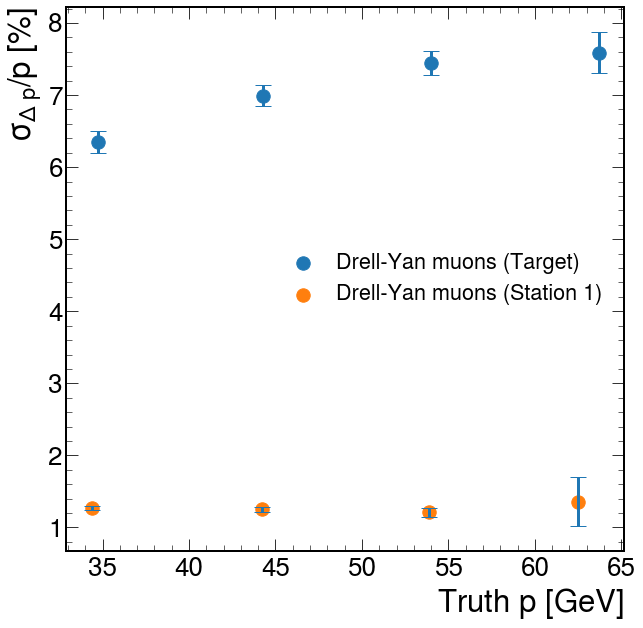

In [4]:
dimuon_resolution_before_fmag(dq_events)
dimuon_resolution_after_fmag(dq_events)

plt.xlabel(r'Truth $p$ [GeV]')
plt.ylabel(r'$\sigma_{\Delta~p}/p$ [%]')

plt.legend()
plt.show()

## A' to muons resolution